In [1]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect
import random


import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections

from apoNN.src.occam import Occam
from apoNN.src.datasets import ApogeeDataset,AspcapDataset
from apoNN.src.utils import get_mask_elem,dump,load
from apoNN.src.plotting import summarize_representation
import apoNN.src.vectors as vector


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA,KernelPCA

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,interaction_only=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

[(['TEFF', 'LOGG', 'LOG10VDOP', 'METALS', 'C', 'N', 'O Mg Si S Ca Ti'], ['C', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni'], ['[C/M]', '[N/M]', '[O/M]', '[Na/H]', '[Mg/M]', '[Al/H]', '[Si/M]', '[S/M]', '[K/H]', '[Ca/M]', '[Ti/M]', '[V/H]', '[Mn/H]', '[Fe/H]', '[Ni/H]'], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])]


In [2]:
#allStar =  load("allStar_training_clean")
#dataset=  AspcapDataset(filename="aspcap_training_clean",tensor_type=torch.FloatTensor,recenter=True)
allStar =  load("allStar_occamlike")
dataset=  AspcapDataset(filename="aspcap_occamlike",tensor_type=torch.FloatTensor,recenter=True)
n_data=10000

In [3]:
feh_outliercut = allStar["Fe_H"]>-5
o_outliercut = allStar["O_FE"]>-5
c_outliercut = allStar["C_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
n_outliercut = allStar["N_FE"]>-5
ni_outliercut = allStar["Ni_FE"]>-5
mn_outliercut = allStar["Mn_FE"]>-5


combined_cut = feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & p_outliercut & s_outliercut & ti_outliercut & cr_outliercut & si_outliercut & n_outliercut & ni_outliercut & mn_outliercut


In [4]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","Ni_FE","N_FE","Cr_FE"] 
#considered_parameters = ["Fe_H"]
y = vector.Vector(np.array([allStar[:n_data][combined_cut[:n_data]][param] for param in considered_parameters])[:,:n_data].T)
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)

In [5]:
occam = load("occam")
allStar_occam = occam["allStar"]
dataset_occam = AspcapDataset(filename="aspcap_occam",recenter=True,tensor_type=torch.FloatTensor,filling_dataset=dataset.dataset["aspcap"])
occam_cluster_idxs = occam["cluster_idxs"]


# Get the z's

In [118]:
compressor = PCA(n_components=20,whiten=False)#z.raw.shape[1],whiten=True)
compressor.fit(dataset.dataset["aspcap_interpolated"])

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [119]:
z_pca = compressor.transform(dataset.dataset["aspcap_interpolated"])
z_pca= z_pca[:n_data]
z = vector.Vector(z_pca[combined_cut[:n_data]],order=1,interaction_only=False)

In [120]:
z_raw_occam = compressor.transform(dataset_occam.dataset["aspcap_interpolated"])
z_occam = vector.OccamLatentVector(occam_cluster_idxs,raw=z_raw_occam,order=1,interaction_only=False)

In [121]:
x_pred_occam = compressor.inverse_transform(compressor.transform(dataset_occam.dataset["aspcap_interpolated"]))

In [122]:
x_pred = compressor.inverse_transform(compressor.transform(dataset.dataset["aspcap_interpolated"]))

(array([2.62616530e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.62616530e-01, 5.25233060e-01, 2.62616851e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.62616851e-01, 1.05046612e+00, 2.62616530e-01,
        5.25233060e-01, 2.62616691e+00, 8.14111742e+00, 1.39186761e+01,
        3.57158700e+01, 7.06438898e+01, 1.62822249e+02, 3.30896929e+02,
        6.28178932e+02, 1.00319545e+03, 1.37479806e+03, 1.62323327e+03,
        1.53079222e+03, 1.21985425e+03, 8.95259888e+02, 5.65413562e+02,
        3.93924916e+02, 2.53425107e+02, 1.57832535e+02, 9.76934090e+01,
        5.30485391e+01, 3.65037200e+01, 2.38981043e+01, 9.19157856e+00,
        3.93925277e+00, 3.41401489e+00, 1.83831571e+00, 5.25233060e-01,
        2.62616851e-01, 2.62616530e-01]),
 array([-3.0651246e-03, -2.9699288e-03, -2.8747329e-03, -2.7795371e-03,
        -2.6843415e-03

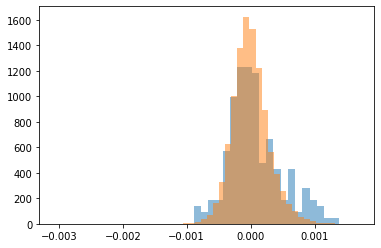

In [123]:
plt.hist(np.mean(x_pred_occam-dataset_occam.dataset["aspcap_interpolated"],axis=1),alpha=0.5,density=True,bins=20)
plt.hist(np.mean(x_pred-dataset.dataset["aspcap_interpolated"],axis=1),alpha=0.5,density=True,bins=50)

In [124]:
np.abs(np.mean(x_pred_occam-dataset_occam.dataset["aspcap_interpolated"],axis=1))[118]

0.0011268732

In [125]:
np.argsort((np.mean(x_pred_occam-dataset_occam.dataset["aspcap_interpolated"],axis=1)))

array([102, 125,  42, 145,  30,  69,  48, 115,  76, 150,  79, 108,  81,
       132,  45,  88, 114,  86, 171,  80,   1,  98,  27, 174,  96,  28,
        87,  84,  74, 139, 155,  10, 146,   4,  47, 148,   8, 147,  33,
       182,  95, 165, 160,  73,  50,  72,  91, 134,   0, 185,  65, 122,
       136,  44,  93,  92, 138,  23,  85, 142, 135,  54, 151, 144,  41,
       161,   6,   7,  90, 168,  38,  21,  31, 143,  94, 166, 154, 158,
       152, 156, 157,   2,  75,  37,  89, 103,  17, 162,  32,  83,  53,
       172,  36, 164,  34,  16, 112, 176,  14,  26,  40,  99,  39,  43,
       184,  15, 178,   3,  20, 163, 149, 124, 159, 175, 169, 141, 170,
       127, 133, 179,  35, 181, 153,  82, 117,  46,   9, 167, 109,  52,
        60, 180, 173,   5,  11,  19,  77, 140,  67, 177, 130, 105,  29,
        49,  63,  24, 131,  25,  62, 110,  22,  70,  68, 128, 183, 137,
        97,  55,  57,  51,  71, 101, 121, 116,  61,  13,  78, 104,  58,
        18,  66, 120,  59,  12, 129, 111, 126, 100,  56, 106, 11

In [126]:
best_idxs = np.argsort(np.mean((x_pred_occam-dataset_occam.dataset["aspcap_interpolated"])**2,axis=1))[:-10]
z_occam = vector.OccamLatentVector(occam_cluster_idxs[best_idxs],raw=z_raw_occam[best_idxs],order=1,interaction_only=False)

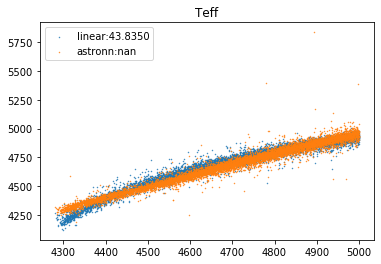

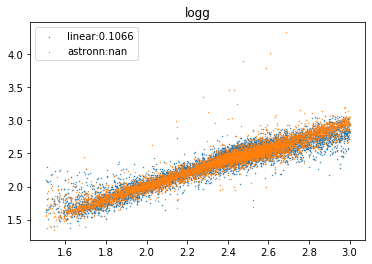

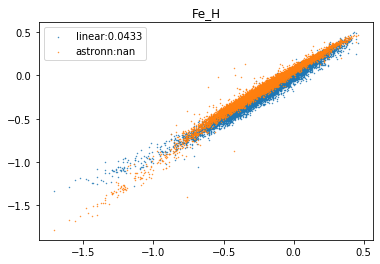

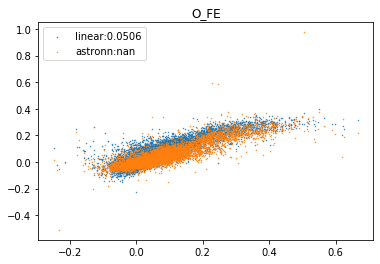

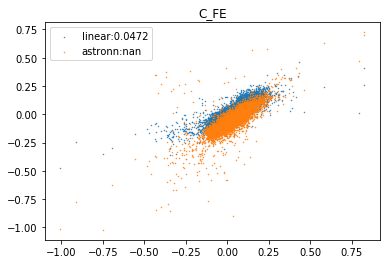

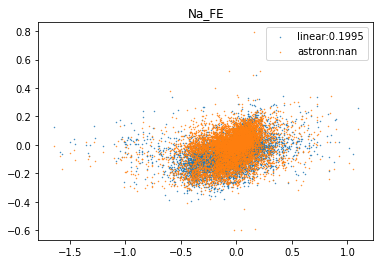

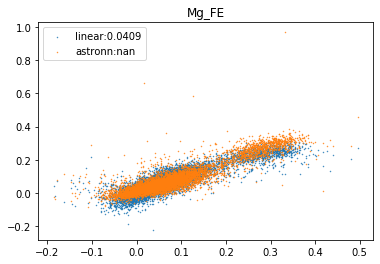

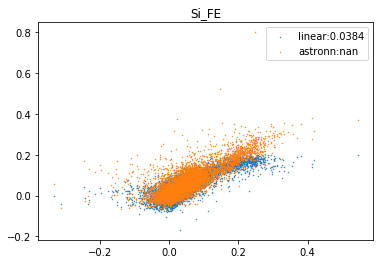

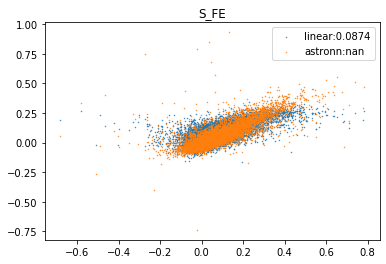

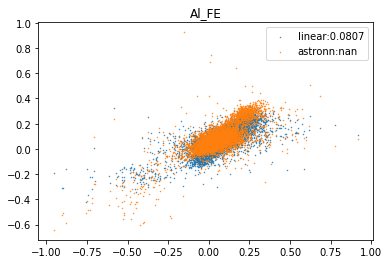

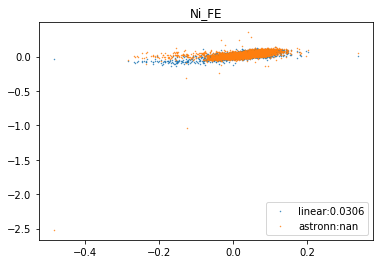

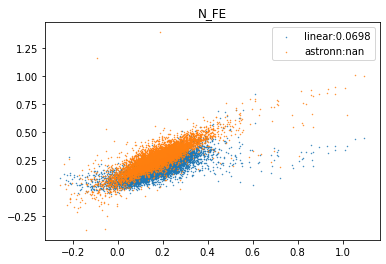

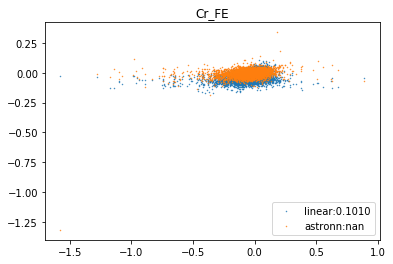

In [127]:
w = vector.LinearTransformation(z,y)
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

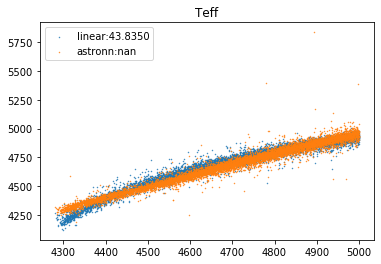

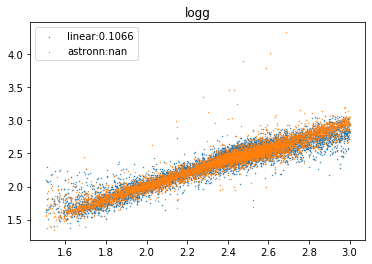

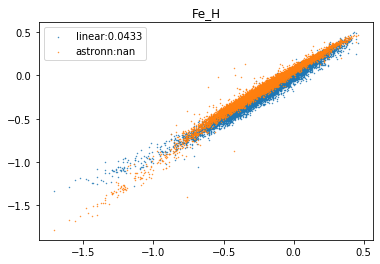

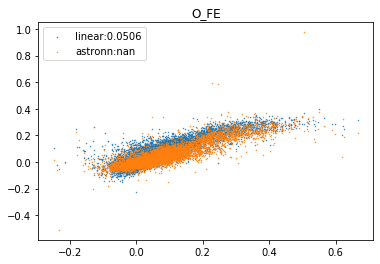

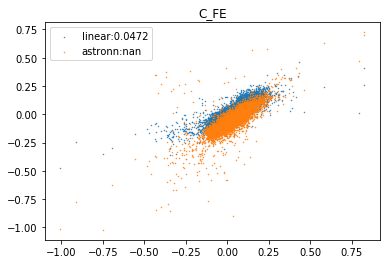

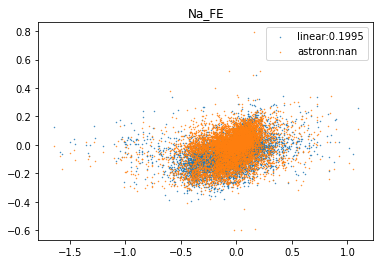

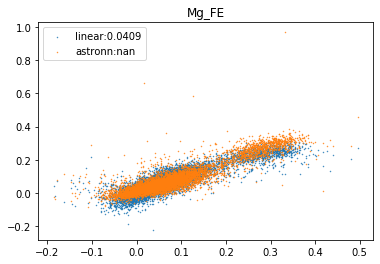

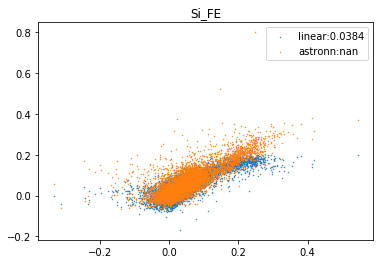

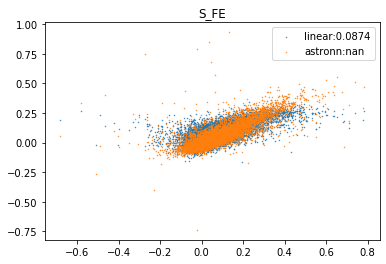

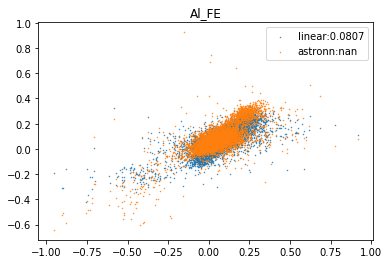

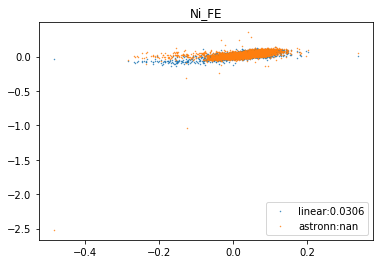

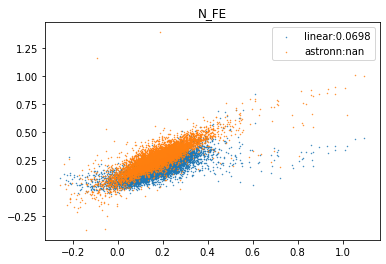

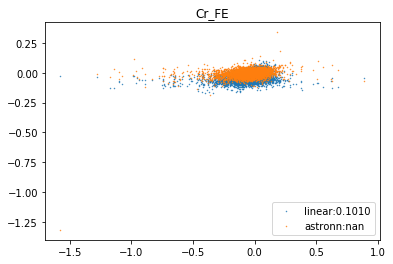

In [128]:
w = vector.LinearTransformation(z,y)
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

### Use the fitter object

In [129]:
fitter = vector.Fitter(z,z_occam)
#fitter = vector.Fitter(z,z_occam.without("NGC 6819"))

In [130]:
fitter.scaling_factor

array([[2.21764684, 1.35603933, 1.33064842, 1.02629366, 0.95405247,
        0.89369313, 0.8556502 , 0.80084012, 0.69795455, 0.64424841,
        0.60108734, 0.56983353, 0.52076514, 0.45004821, 0.38983209,
        0.34406035, 0.26108656, 0.24926128, 0.20613212, 0.14491874]])

In [131]:
v_centered_occam = fitter.transform(z_occam.centered.only("NGC 6819"))
v = fitter.transform(fitter.z.centered)

occam: 0.5983960791169494
raw: 24.91433655088902
ratio: 41.63519351205476


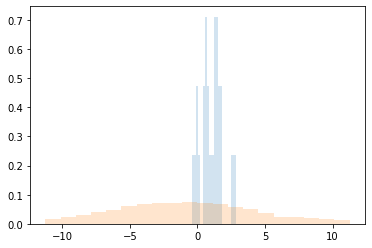

In [133]:
summarize_representation(v[:,19],v_centered_occam[:,19],0.1,0.1)

In [ ]:
def get_combinations(len_cluster):
    combinations = []
    for idx1 in np.arange(len_cluster):
        for idx2 in np.delete(np.arange(len_cluster),idx1):
            if sorted([idx1,idx2]) not in combinations:
                combinations.append(sorted([idx1,idx2]))
    return combinations

In [ ]:
def get_intracluster_distances(z,z_occam):
    distances = []
    for cluster in list(z_occam.registry.keys()):
        fitter = vector.Fitter(z,z_occam.without(cluster))
        #fitter = vector.Fitter(z,z_occam)
        v_centered_occam = fitter.transform(z_occam.centered.only(cluster))
        combinations = get_combinations(len(v_centered_occam))
        distances_cluster = []
        distances_cluster_random = []
        for combination in combinations:
            distances_cluster.append(np.linalg.norm(v_centered_occam[combination[0]]-v_centered_occam[combination[1]]))

        distances.append(distances_cluster)
    return distances

In [ ]:
def get_intercluster_distances(z,z_occam,n_random = 200):
    distances = []
    for cluster in list(z_occam.registry.keys()):
        fitter = vector.Fitter(z,z_occam.without(cluster))
        v_centered_occam = fitter.transform(z_occam.centered.only(cluster))
        #v = fitter.transform(z_occam.centered.without(cluster))
        v = fitter.transform(fitter.z.centered)
        n_v = len(v)
        distances_cluster = []
        for idx in np.arange(len(v_centered_occam)):
            for _ in np.arange(n_random):
                random_idx = random.randint(0,n_v-1)
                distances_cluster.append(np.linalg.norm(v_centered_occam[idx]-v[random_idx]))

        distances.append(distances_cluster)
    return distances

In [ ]:
#distances = get_intracluster_distances(z,z_occam.without("NGC 6791"))
#random_distances = get_intercluster_distances(z,z_occam.without("NGC 6791"))
distances = get_intracluster_distances(z,z_occam)
random_distances = get_intercluster_distances(z,z_occam)

In [ ]:
mean_distances = [np.mean(i) for i in distances]
mean_random_distances = [np.mean(i) for i in random_distances]

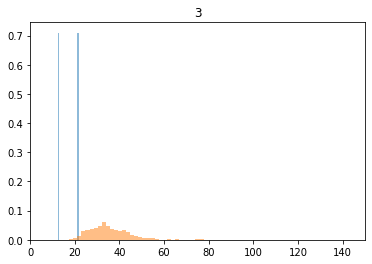

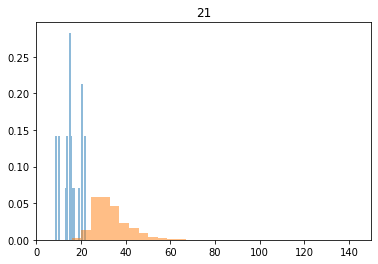

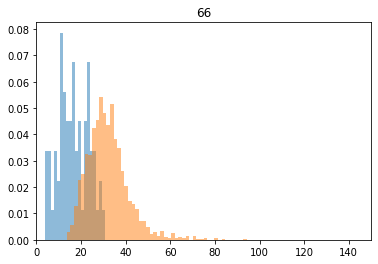

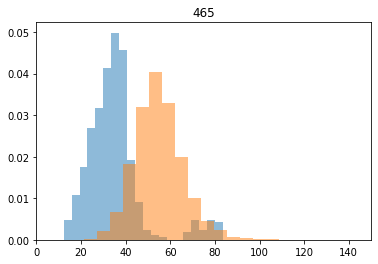

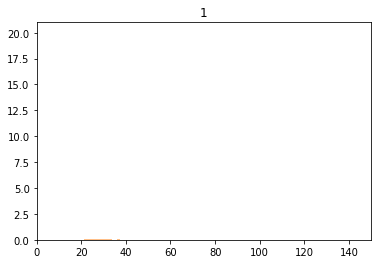

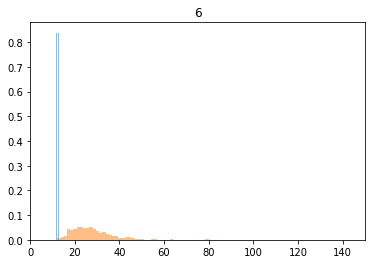

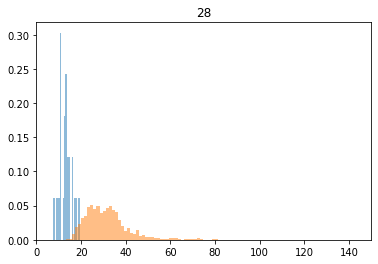

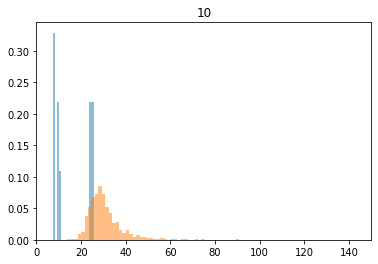

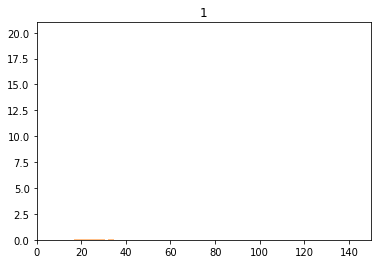

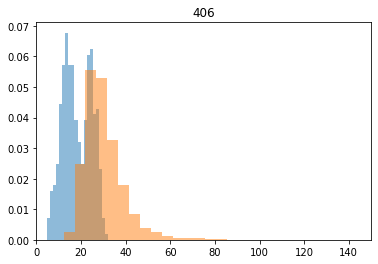

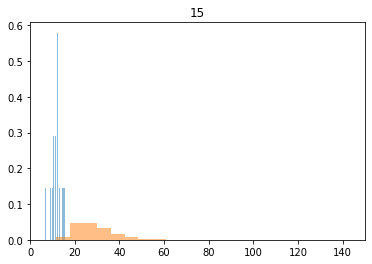

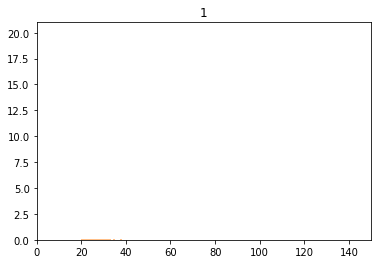

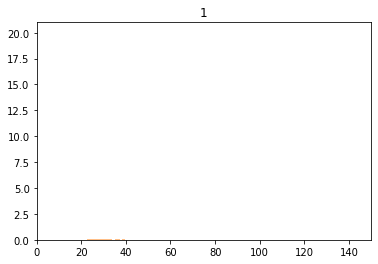

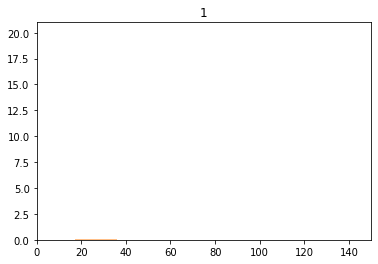

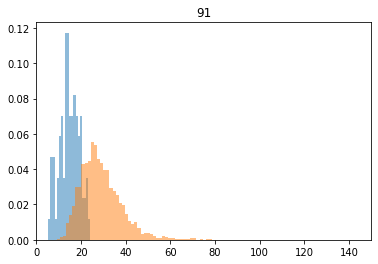

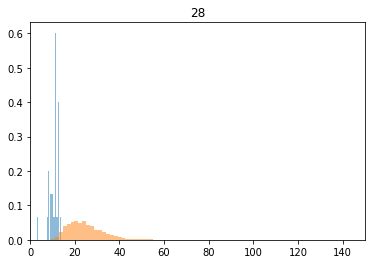

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


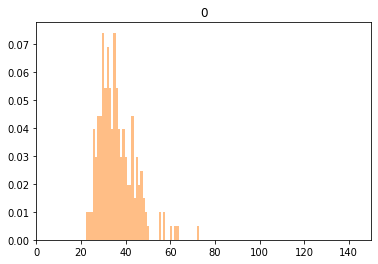

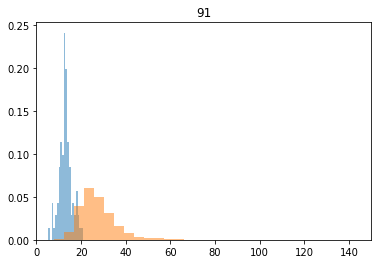

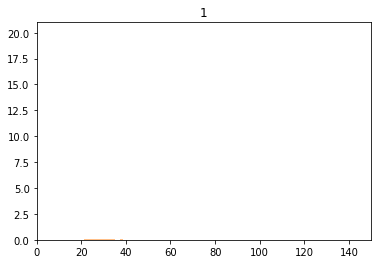

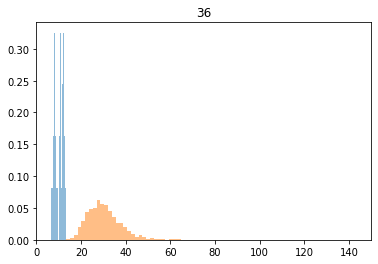

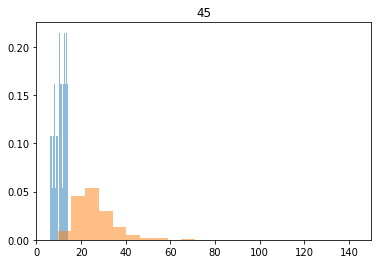

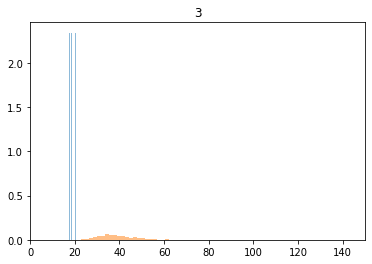

In [106]:
for i in range(len(distances)):
    plt.title(len(distances[i]))
    plt.hist(distances[i],alpha=0.5,density=True,bins=20)
    plt.hist(random_distances[i],alpha=0.5,density=True,bins=50)
    plt.xlim(0,150)
    plt.show()

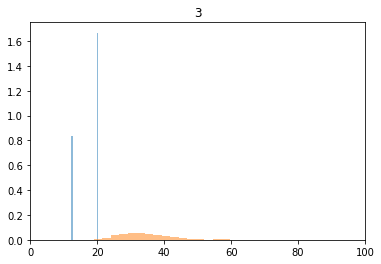

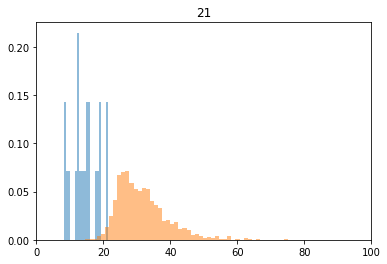

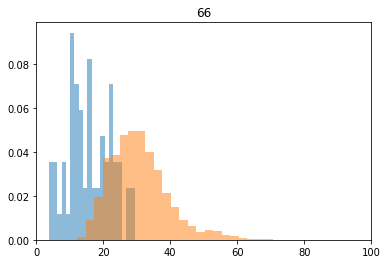

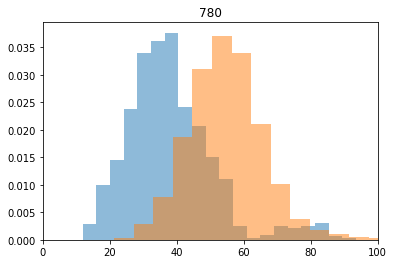

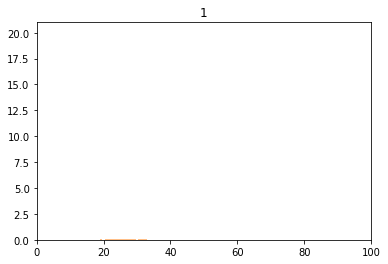

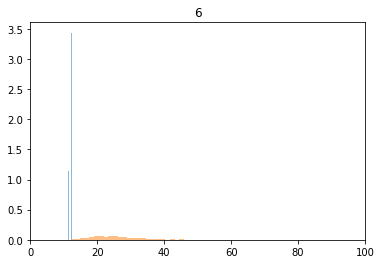

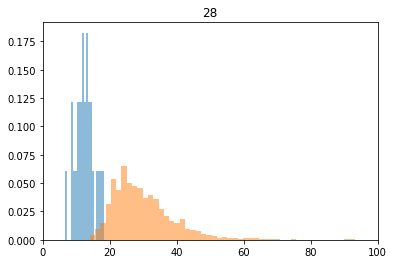

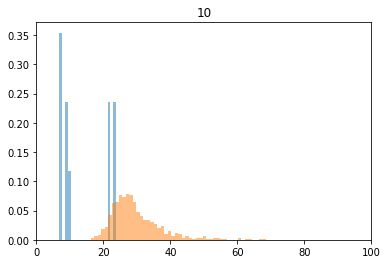

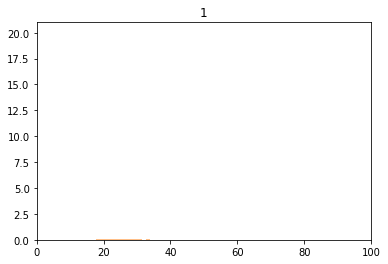

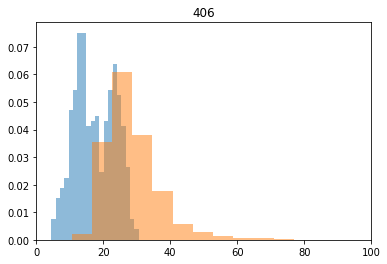

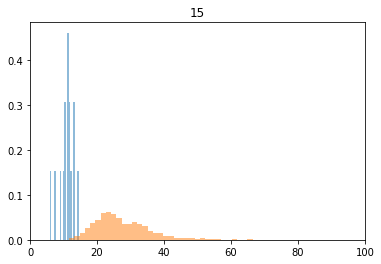

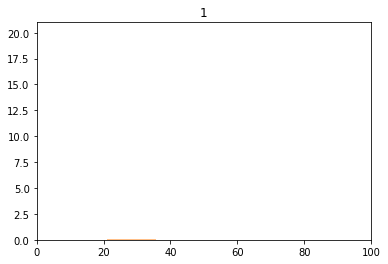

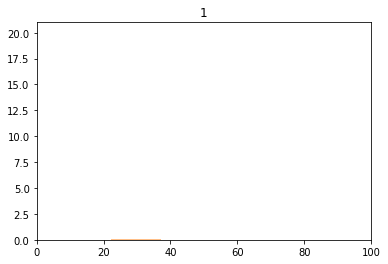

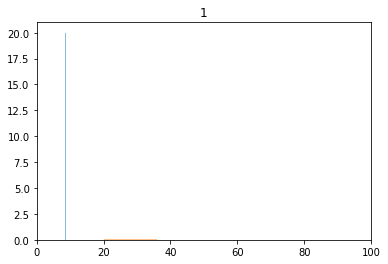

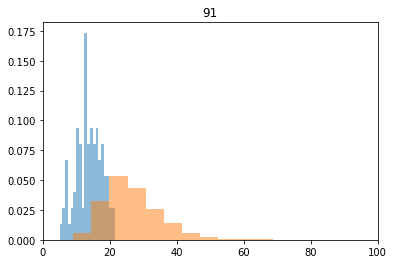

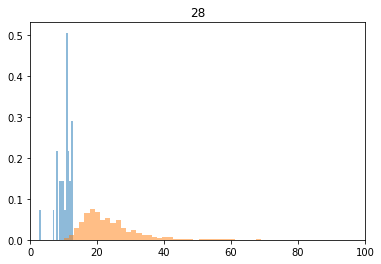

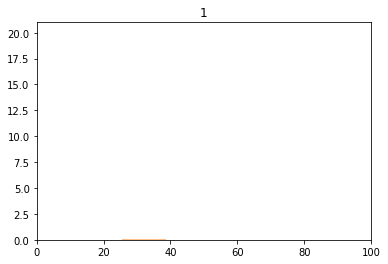

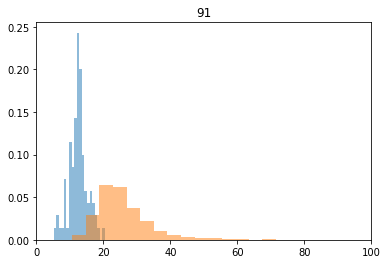

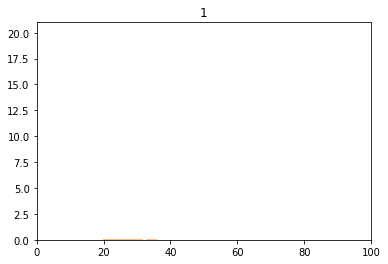

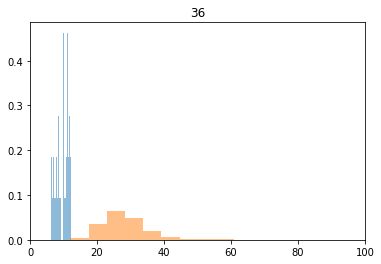

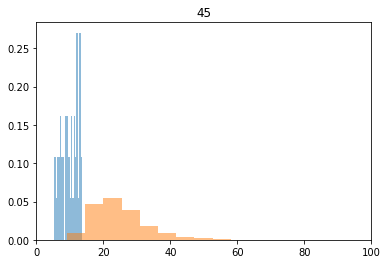

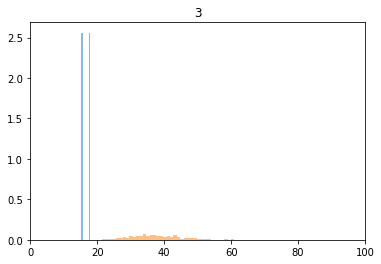

In [51]:
for i in range(len(distances)):
    plt.title(len(distances[i]))
    plt.hist(distances[i],alpha=0.5,density=True,bins=20)
    plt.hist(random_distances[i],alpha=0.5,density=True,bins=50)
    plt.xlim(0,100)
    plt.show()

### Now try with y

In [134]:
y_occam = vector.Vector(np.array([allStar_occam[param] for param in considered_parameters])[:,:n_data].T)
#y_occam = vector.OccamLatentVector(occam_cluster_idxs,raw=y_occam(),order=1,interaction_only=False)
y_occam = vector.OccamLatentVector(occam_cluster_idxs[best_idxs],raw=y_occam()[best_idxs],order=1,interaction_only=False)

occam: 0.0005096307249401417
raw: 0.034505464136600494
ratio: 67.7067971925227


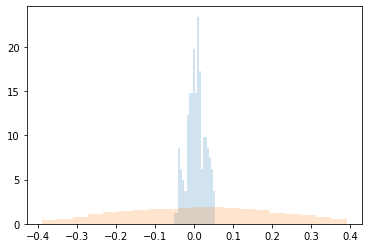

In [149]:
summarize_representation(y.centered()[:,2],y_occam.cluster_centered()[:,2],0.1,0.1)

In [152]:
np.argsort(np.abs(y_occam.cluster_centered()[:,2]))

array([139,  39,   4,  47, 135,  59,  75, 172, 103,  97,  54, 148, 110,
        41, 130, 147, 134,  65,   6,  15, 143,  34,  76,  61,  72, 107,
        30,  89, 142,   9, 155, 120, 168,  95, 131,  66, 117,  40, 105,
        31,  46, 104,  57, 166,  81,  62, 137,   1, 101, 109,  23,  42,
        45, 138,  19, 158,  43,  68,  29,  32,  93,   0,  99,  11,   5,
        44,  91,  60,  58, 164,  27,  83, 124,  55, 136,  67,   7,  92,
        14,  90,  37, 115,  17, 144, 125,  24,  36,  20, 116,  87, 161,
       152,  13,  74,  70, 169,  85,  63, 112, 108, 141, 127,  98, 149,
        52, 118,  16, 126, 133, 119,  50, 146, 123,  18, 106,  53,  25,
        78,  28,  86,  79,  94,  96,  38,  69,  48,  10, 145, 151,  33,
       113,  82,  56,  26,   3,  84,  73, 150,  71,   8,  77, 102, 121,
        49,  64, 171, 173,  80, 167,  12, 140, 175, 174, 170,   2, 100,
       162, 153, 111, 163,  21,  35,  51,  88, 128, 132, 154, 157, 114,
       122,  22, 160, 156, 159, 165, 129])

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   3., 125.,  46.]),
 array([-0.66704446, -0.59077146, -0.51449846, -0.43822546, -0.36195246,
        -0.28567946, -0.20940646, -0.13313346, -0.05686046,  0.01941254,
         0.09568554]),
 <a list of 10 Patch objects>)

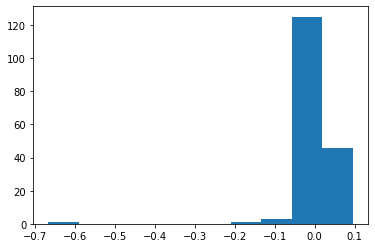

In [166]:
plt.hist(y_occam.cluster_centered()[:,2])

In [108]:
for i in range(20):
    print(i)
    print(np.min(y_occam.raw[:,i]))
    print(np.min(y_occam.raw[:,i]))

0
4031.929
4031.929
1
1.5029786
1.5029786
2
-0.51088154
-0.51088154
3
-0.10402401
-0.10402401
4
-0.09533
-0.09533
5
-0.5415939
-0.5415939
6
-0.06812229
-0.06812229
7
-0.079233974
-0.079233974
8
-0.19050601
-0.19050601
9
-0.2678855
-0.2678855
10
-0.094757915
-0.094757915
11
-0.117345
-0.117345
12
-0.644212
-0.644212
13


IndexError: index 13 is out of bounds for axis 1 with size 13

In [109]:
y_occam.raw[:,8].shape

(186,)

In [110]:
#distances_y = get_intracluster_distances(y,y_occam.without("NGC 6791"))
#random_distances_y = get_intercluster_distances(y,y_occam.without("NGC 6791"))
distances_y = get_intracluster_distances(y,y_occam)
random_distances_y = get_intercluster_distances(y,y_occam)

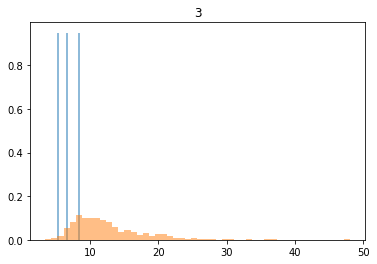

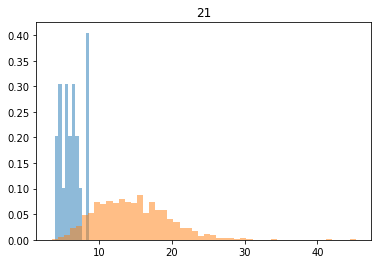

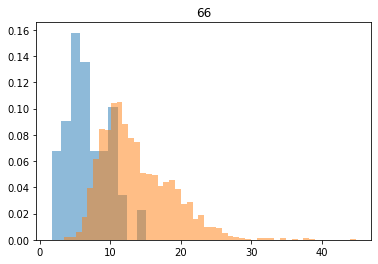

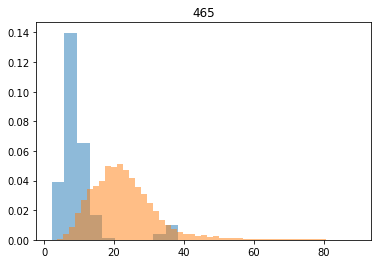

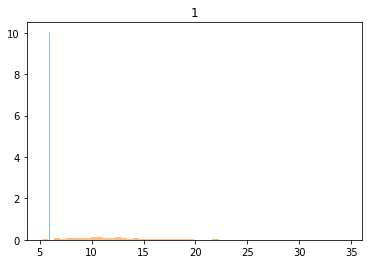

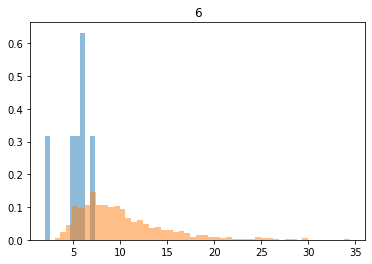

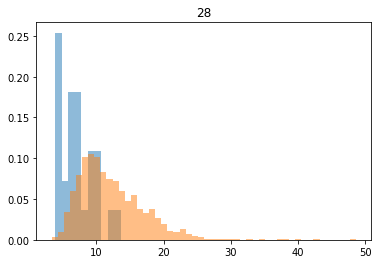

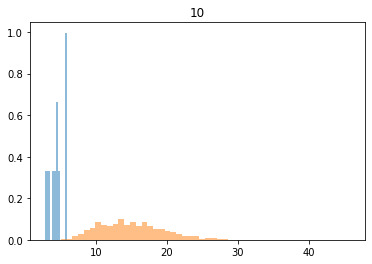

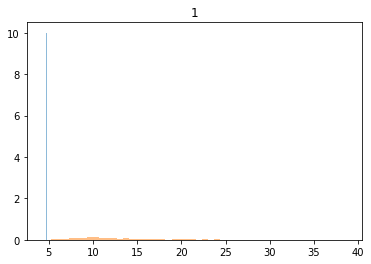

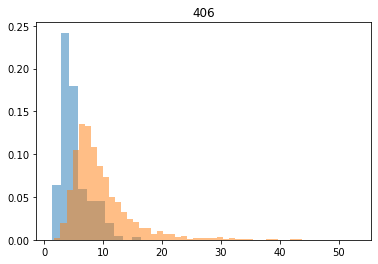

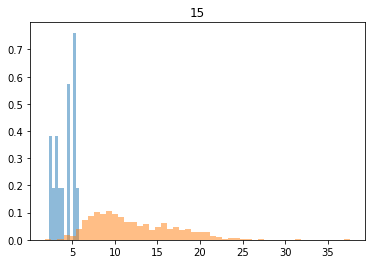

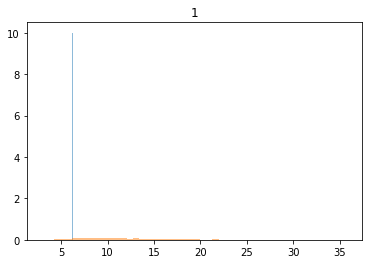

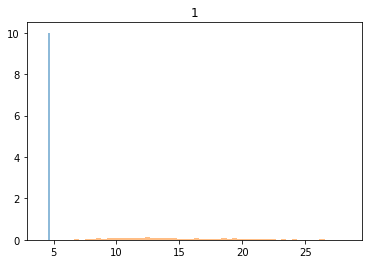

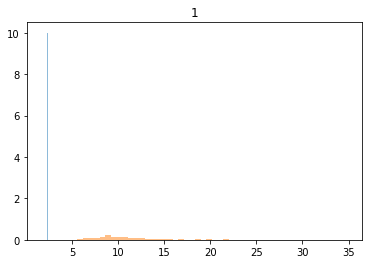

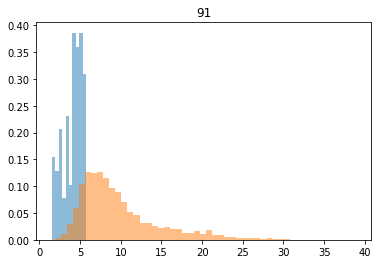

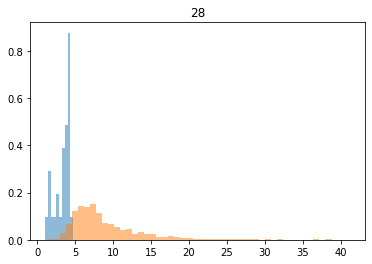

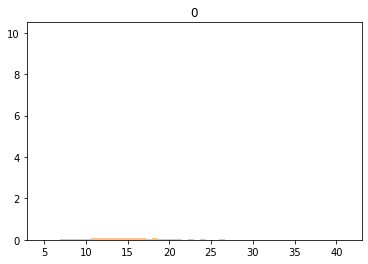

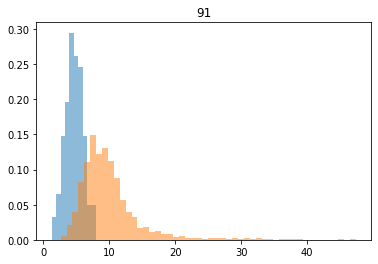

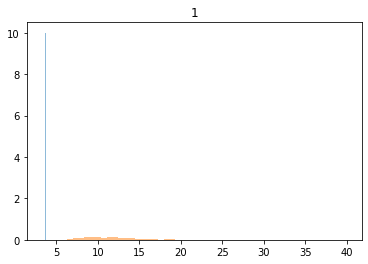

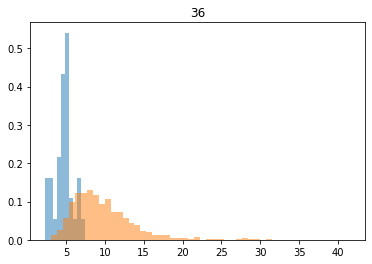

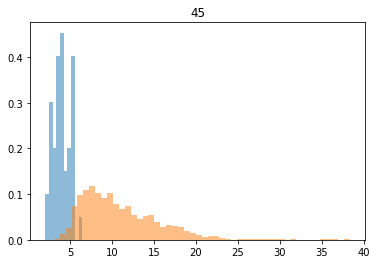

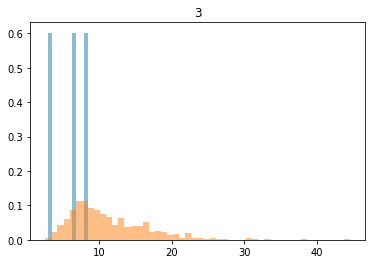

In [111]:
for i in range(len(distances)):
    plt.title(len(distances[i]))
    plt.hist(distances_y[i],alpha=0.5,density=True,bins=10)
    plt.hist(random_distances_y[i],alpha=0.5,density=True,bins=50)
    plt.show()

### Now try with y_astronn

In [52]:
y_astronn_occam = vector.AstroNNVector(allStar_occam,considered_parameters)
y_astronn_occam = vector.OccamLatentVector(occam_cluster_idxs,raw=y_occam(),order=1,interaction_only=False)

In [53]:
distances_y = get_intracluster_distances(y_astronn,y_astronn_occam)
random_distances_y = get_intercluster_distances(y_astronn,y_astronn_occam)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
for i in range(len(distances)):
    plt.title(len(distances[i]))
    plt.hist(distances_y[i],alpha=0.5,density=True,bins=20)
    plt.hist(random_distances_y[i],alpha=0.5,density=True,bins=50)
    plt.show()

In [ ]:
for i in range(len(distances)):
    plt.title(len(distances[i]))
    plt.hist(distances_y[i],alpha=0.5,density=True,bins=20)
    plt.hist(random_distances_y[i],alpha=0.5,density=True,bins=50)
    plt.show()

In [ ]:
considered_parameters

In [ ]:
allStar_occam

In [ ]:
upper_temp_cut = allStar["Teff"]<5500
lower_temp_cut = allStar["Teff"]>4000
snr_cut = allStar_occam["SNR"]>250
snr_highcut = allStar_occam["SNR"]<500
aspcapflag = allStar_occam["ASPCAPFLAG"]==0
starflag = allStar_occam["starflag"]==0
vscatter_cut = allStar_occam["VSCATTER"]<1


In [ ]:
sum(starflag)

In [ ]:
for cluster in z_occam.registry:
    print(cluster)
    print(len(get_combinations(len(z_occam.registry[cluster]))))

In [ ]:
plt.hist(y.raw[z_occam.registry["NGC 6791"]])

In [ ]:
plt.hist(allStar.SNR)

In [ ]:
plt.hist(allStar_occam.SNR)

In [ ]:
allStar_occam.SNR.sort()

In [ ]:
allStar_occam.SNR

In [ ]:
np.argsort(allStar_occam.SNR)

In [ ]:
occam_cluster_idxs[52]

In [ ]:
allStar_occam.SNR[52]

In [ ]:
plt.hist(allStar_occam.SNR)

In [ ]:
allStar= apread.allStar(rmcommissioning=True,main=False,ak=True, akvers='targ',adddist=False)


upper_temp_cut = allStar["Teff"]<5000                                            
lower_temp_cut = allStar["Teff"]>4000                                            
lower_g_cut = allStar["logg"]>1.5                                                
upper_g_cut = allStar["logg"]<3.0


training_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut       
training_cut_allStar = allStar[training_cut][:50000]                             



In [ ]:
len(allStar[training_cut])

In [ ]:
plt.hist(training_cut_allStar.SNR,bins=300,density=True,alpha=0.5)
plt.hist(allStar_occam.SNR,bins=50,density=True,alpha=0.5)
plt.xlim(0,500)

In [ ]:
plt.plot(dataset_occam.dataset["aspcap"][123])

In [ ]:
plt.plot(dataset_occam.dataset["aspcap"][13])
plt.xlim(6000,7000)

In [ ]:
plt.plot(dataset_occam.dataset["aspcap_interpolated"][105])

In [ ]:
plt.plot(dataset_occam.dataset["aspcap_interpolated"][19])

In [ ]:
np.argsort(allStar_occam.SNR)


In [ ]:
len(allStar_occam.SNR[13]

In [ ]:
len(allStar_occam.SNR)

In [ ]:
len(allStar_occam.SNR

In [ ]:
import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import numpy as np
import matplotlib.pyplot as plt 
import torch


from apoNN.src.datasets import ApogeeDataset,AspcapDataset
from apoNN.src.utils import dump as dump 
from apoNN.src.utils import load as load 

apogee_path.change_dr(16)

allStar= apread.allStar(rmcommissioning=True,main=False,ak=True, akvers='targ',adddist=False)


upper_temp_cut = allStar["Teff"]<5000
lower_temp_cut = allStar["Teff"]>4000
lower_g_cut = allStar["logg"]>1.5
upper_g_cut = allStar["logg"]<3.0


training_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut
training_cut_allStar = allStar[training_cut][:30000]



In [ ]:


dataset_clean=  AspcapDataset(filename="aspcap_training_clean",tensor_type=torch.FloatTensor,recenter=True)



dataset = AspcapDataset(training_cut_allStar[:30],filling_dataset=dataset_clean.dataset["aspcap"])
#dataset.dump("aspcap_occamlike")
#dump(training_cut_allStar,"allStar_occamlike")


In [ ]:
training_cut_allStar["apogee_id"]

In [ ]:
list(training_cut_allStar["apogee_id"]).index("2M05452122+6548109")

In [ ]:
list(training_cut_allStar["apogee_id"]).index("2M00235018+5758356")

In [ ]:
list(training_cut_allStar["apogee_id"]).index("2M00235114-7154511")

In [ ]:
list(training_cut_allStar["apogee_id"]).index("2M03395041+6332445")

In [ ]:
list(training_cut_allStar["apogee_id"]).index("2M05451945+5114213")